# Directed Studies Research Project
## Patient Health Prediction Using Multiple Machine Learning Models 

_Trevor Rae_

_Dr. Jabbari_

## Abstract

This research project began pre-COVID19 in partnership with Victoria Lipid Clinic (VLC). Working with VLC, I intended to take a combination of hardcopy admission records and digitize them as well as existing electronic medical records (EMR), which primarily consisted of multiple lab results over time for patients. I had also planned on digitalizing the referal records for patients we had selected to conduct an analysis on. To recap:

Intended Data Set:
Admission Records - Referral Information - Electronic Medical Records 


## 1 Introduction

The program contained in this Jupyter Notebook is intended to be utilized when data can be collected safely from the Victoria Lipid Clinic. In its current state, is is running on mock artificially generated data. The VLC is a clinic located in downtown Victoria, BC, which specializes in patients who have heart conditions requiring specialist care. A large subset of their patients are afflicted with Type 1 (Inherited) or Type 2 (Non Inherited) Hypercholesterolemia. These patients obtain regular lab work to monitor their condition. Upon collection of real patient data, this program can be used for a wide range of data analyses and predictions. This program is currently configured to determine a patient's chance of improval based on previous lab work, but with a few modifcations, can be used for other learning objectives. 

## 2 Program Preamble

### 2.1 Imports and Warning Assignment

This section imports the libraries we will need for our program to run. It also removes all warnings from propagating through the file.

In [359]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### 2.2 Dataset and Model Classes

This section creates the DatasetClass and the ModelClass used in the program. Machine Learning Models are stored here, as are the datasets.

In [238]:
class DatasetClass:    
    def __init__(self, name, X, y, features, samplingModel=None):
        self.name = name
        self.X = X
        self.y = y
        self.features = features
        self.samplingModel = samplingModel #defaulted to None as it's not required
        self.results = None
class ModelClass:
    def __init__(self, name, actualModel):
        self.name = name
        self.actualModel = actualModel

### 2.3 Global Variable Declaration

This section declares the global variables used in this program. This includes the output we are expecting from the Machine Learning Models, the g_modelClasses where each of the Machine Learning Models will be stored, and the g_splits array where the training and testing percentage splits are declared.

In [239]:
g_orderResults = ['Accuracy', 'Precision', 'Recall', 'F_Measure', 'Cross_Validation']

g_numResults = len(g_orderResults)

g_modelClasses = []

g_splits = np.array([0.2, 0.4, 0.6, 0.8])

g_underSampleModels = []
g_overSampleModels = []
g_comboSampleModels = []

### 2.4 Loading in Data From CSV Files

This section pulls in data from given csv files. It removes the key, which is the first column in the csv file. In this project, the key is a patient identifier, and thus does not need to be included. After normalizing the data, it separates the classifier (Y = patient's improvement) from patient data (X= lab values, demographic information). The last column in the csv file contains Y. It then returns this data as a dataset. 

In [240]:
def load_csv_data(csv_file_path, ignoreKey):
    data = pd.read_csv(csv_file_path)                   
    startIndex = 0
    if ignoreKey:
        startIndex = 1
    rawX = data.iloc[:,startIndex:-1].values  # -1 <-- leave the last column for y
    maxX = np.max(rawX, axis=0)
    minX = np.min(rawX, axis=0)
    avgX = np.mean(rawX, axis=0)
    X = (rawX-minX)/(maxX-minX)
    y = data.iloc[:,-1:].values
    y = np.ravel(y)
    NameNoCSV = csv_file_path[:-4]
    dsc = DatasetClass(NameNoCSV, X, y, data.columns[startIndex:-1])
    
    return dsc

## 3 Machine Learning Integration

### 3.1 Model Creation

In this section, machine learning models that can be applied to this data set are imported from the SKLearn library and added to g_modelClasses, which stores all models each data set will be run on.

In [253]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
g_modelClasses.append(ModelClass("LogReg", logreg))
logreg_weight = LogisticRegression(class_weight={1:10, 0:1})
g_modelClasses.append(ModelClass("LogRegW", logreg_weight))

from sklearn.linear_model import Perceptron
percep = Perceptron()
g_modelClasses.append(ModelClass("Perceptron", percep))
percep_weight = Perceptron(class_weight={1:10, 0:1})
g_modelClasses.append(ModelClass("PerceptronW", percep_weight))


from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
g_modelClasses.append(ModelClass("RandomForestClassifier", rfc))
rfc_weight = RandomForestClassifier(class_weight={1:10, 0:1})
g_modelClasses.append(ModelClass("RandomForestClassifierW", rfc_weight))

from sklearn import svm
svmsvc = svm.SVC()
g_modelClasses.append(ModelClass("SVM", svmsvc))
svmsvc_weight = svm.SVC(class_weight={1:10, 0:1})
g_modelClasses.append(ModelClass("SVMW", svmsvc_weight))

from sklearn.svm import LinearSVC
linearsvc = LinearSVC()
g_modelClasses.append(ModelClass("LinearSVC", linearsvc ))

from sklearn.ensemble import BaggingClassifier
baggingKNeighbors = BaggingClassifier(KNeighborsClassifier())
g_modelClasses.append(ModelClass("BaggingKNeighbors", baggingKNeighbors))
baggingLogistic = BaggingClassifier(LogisticRegression())
g_modelClasses.append(ModelClass("BaggingLogistic", baggingLogistic))
baggingPerceptron = BaggingClassifier(Perceptron())
g_modelClasses.append(ModelClass("BaggingPerceptron", baggingPerceptron))
baggingNaive = BaggingClassifier(GaussianNB())
g_modelClasses.append(ModelClass("BaggingNaive", baggingNaive))
baggingDecision = BaggingClassifier()
g_modelClasses.append(ModelClass("BaggingDecision", baggingDecision))
baggingRandom = BaggingClassifier(RandomForestClassifier())
g_modelClasses.append(ModelClass("BaggingRandom", baggingRandom))
baggingSVM = BaggingClassifier(svm.SVC())
g_modelClasses.append(ModelClass("BaggingSVM", baggingSVM))

from sklearn.ensemble import AdaBoostClassifier
AdaBoost= AdaBoostClassifier(n_estimators=1000)
g_modelClasses.append(ModelClass("AdaBoost", AdaBoost))

from sklearn.ensemble import GradientBoostingClassifier
GradientBoosting = GradientBoostingClassifier(n_estimators=1000)
g_modelClasses.append(ModelClass("GradientBoosting", GradientBoosting))

from sklearn.ensemble import VotingClassifier
HardVoting = VotingClassifier(estimators=[('LogReg', logreg), ('DecisionTree', tree), ('Perceptron', percep), ('NaiveBayes', nb), ('knn', knn1), ('svc', svmsvc), ('RandomForestClassifier', rfc)],voting='hard')
g_modelClasses.append(ModelClass("HardVoting", HardVoting))
SoftVoting = VotingClassifier(estimators=[('LogReg', logreg), ('DecisionTree', tree), ('NaiveBayes', nb), ('knn', knn1),('RandomForestClassifier', rfc)],voting='soft')
g_modelClasses.append(ModelClass("SoftVoting", SoftVoting))

### 3.2 Model Evaluation

This section takes all of the SKLearn Machine Learning models and runs a given data set on each of them, returning a NP Array containing: 

1. Accuracy 
2. Precision 
3. Recall 
4. F_Measure 
5. Cross_Validation 

For each of the models included in the Model Creation Section

In [243]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.model_selection import cross_val_score

def evaluate_model(modelClass, dataset, X_train, y_train, X_test, y_test):
    model = modelClass.actualModel
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    numYPred1 = sum(y_pred == 1)
    if (numYPred1 == 0):
        print(dataset.name, modelClass.name, "Pred Num1:", sum(y_pred == 1), "Num0:", sum(y_pred == 0), "Len:", len(y_pred))
        print(dataset.name, modelClass.name, "Test Num1:", sum(y_test == 1), "Num0:", sum(y_test == 0), "Len:", len(y_test))
        print(dataset.name, modelClass.name, "Train Num1:", sum(y_train == 1), "Num0:", sum(y_train == 0), "Len:", len(y_train))
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)    
    f1_score = metrics.f1_score(y_test, y_pred)
    # cross validation is invalid if we do under/over sampling
    crossValidationScore = 0
    if (dataset.samplingModel is None):
        scores = cross_val_score(model, dataset.X, dataset.y, cv=10)
        crossValidationScore = scores.mean()

    # ORDER MUST MATCH g_orderResults = ['Accuracy', 'Precision', 'Recall', 'F_Measure', 'Cross_Validation']
    return np.array([[accuracy, precision, recall, f1_score, crossValidationScore]])


def evaluate_all_models(dataset, X_train, y_train, X_test, y_test):
    npResults = np.empty((0, g_numResults))
    for modelClass in g_modelClasses:
        newResult = evaluate_model(modelClass, dataset, X_train, y_train, X_test, y_test)
        npResults = np.append(npResults, newResult, axis=0)
    return npResults

## 4 Data Processing

### 4.1 Dataset Input

**Dataset 1: Snapshot look**

The intial data set being shown is a single look at the patients based on their first lab report. The patients are admitted as either healthy or sick. In this dataset, Y= healthy or sick. 

In [290]:
dataset1 = load_csv_data("labs1.csv", True) 
#evaluate_all_models(dataset,dataset.X,dataset.y,dataset.X,dataset.y)

**Dataset 2: Moderated Patient Improvement Over Time**

The second dataset being analysed reflects healthy OR sick patients over N lab results (N=4), where the results of their labs were modulated to be more or less likely to become healthier or sicker based on the patient's classification as sicker or healthier. This is also the criteria on which the model is predicting (Y=healthier or sicker).

In [291]:
dataset2 = load_csv_data("labs2.csv", True) 
#evaluate_all_models(dataset2,dataset2.X,dataset2.y,dataset2.X,dataset2.y)

**Dataset 3: Patients who consistently get healthier or sicker**

The third and final dataset being analysed is one where patients are admitted as either healthy or sick, and either improve or decline in health as per their lab values over time. The model is predicting if a patient will be getting healthier or sicker, regardless of their admission status of healthy or sick.

In [292]:
dataset3 = load_csv_data("labs3.csv", True) 
#x = evaluate_all_models(dataset3,dataset3.X,dataset3.y,dataset3.X,dataset3.y)

Each of these datasets are now added to a larger grouping for downstream analysis against each of the ML models

In [293]:
datasetClasses = []
datasetClasses.append(dataset1)
datasetClasses.append(dataset2)
datasetClasses.append(dataset3)

datasetClassesJust1 = []
datasetClassesJust1.append(dataset1)

datasetClassesJust2 = []
datasetClassesJust2.append(dataset2)

datasetClassesJust3 = []
datasetClassesJust3.append(dataset3)


### 4.2 Splits and Dataset Evaluation

Once the datasetClasses have been created, they are run for X number of iterations (X=?) for each of the training and testing splits specified in the g_splits array in Section 2.3. For each of those splits and for X iterations, each dataset is run for each of the models in the g_modelClasses array created in Section 3. The results are then attached to the datasetClass.

In [294]:
from sklearn.model_selection import train_test_split
def averageXIterationsOnSplits(dataset, iterations):
    averageSplitResults = []
    for index in range(len(g_splits)):
        averageSplitResults.append(np.zeros((len(g_modelClasses), g_numResults)))
    for index in range(iterations):
        splitIndex = 0
        for split in g_splits:
            X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=split, random_state=4)
            if not (dataset.samplingModel is None):
                X_temp, y_temp = dataset.samplingModel.actualModel.fit_resample(X_train, y_train)
                X_train = X_temp
                y_train = y_temp
            npResults = evaluate_all_models(dataset, X_train, y_train, X_test, y_test)
            averageSplitResults[splitIndex] += npResults
            splitIndex += 1
    for asr in averageSplitResults:
        asr /= iterations
    dataset.results = averageSplitResults

To gather results for all of our datasets, we run the averageXIterationsOnSplits function on all generated datasets

In [301]:
numberOfIterations = 1
averageXIterationsOnSplits(dataset1,numberOfIterations)
averageXIterationsOnSplits(dataset2,numberOfIterations)
averageXIterationsOnSplits(dataset3,numberOfIterations)

### 4.3 Results 

Now that each dataset has been run against each model, the functions graphTopXStatInfo and getTopXForAllDatasets can be used to display the top X models across the datasets!

In [353]:
def graphTopXStatInfo(topStatInfo):
    statIndex =0
    for topStat in topStatInfo:
        results=[]
        x_label =[]
        for top in topStat:
            if type(top) == int:
                print('Cross Validation is 0 for Under/Over/Combo Samples')
                print('\n')
                return
            counter = 0
            for list_item in top:
                if counter ==0:
                    dataset_name = list_item
                    counter +=1
                elif counter ==1:
                    modelclass_name = list_item
                    counter +=1
                elif type(list_item) == np.ndarray:
                    list_item.tolist()
                    list_element = list_item[statIndex]
                elif type(list_item) ==np.float64:
                    list_item = str(list_item)
                    split_index = list_item                    
            x_label.append(dataset_name + ' ' + modelclass_name + ' ' + split_index)
            results.append(list_element)            
        y_pos = np.arange(len(topStat)) 
        plt.figure(figsize=(10,10))
        plt.title(f'Top {len(topStat)} in terms of {g_orderResults[statIndex]}', fontsize=28)
        width = list(0.5 for i in y_pos)
        plt.bar(y_pos, results, width=width)
        plt.xticks(y_pos, x_label, fontsize=16, rotation=90)
        plt.xlabel('File Name, Classification Model, and Test Split Size', fontsize=20)
        plt.yticks(fontsize=16)
        plt.ylabel('Percentage',fontsize=20)
        yerror = np.std(results)
        plt.errorbar(y_pos,results,yerr=yerror,fmt="o", ecolor='black', capsize=5)
        plt.show()           
        statIndex +=1
        
def getTopXForAllDatasets(datasetClasses, topX):
    topStat = []
    topStatInfo = []
    for x in range(g_numResults):
        topXStats = [0] * topX
        topStat.append(topXStats)
        topXStatsInfo = ["" for x in range(topX)]
        topStatInfo.append(topXStatsInfo)
    topStatInfo = np.zeros([g_numResults, topX],dtype=object)
    for dataset in datasetClasses:
        splitIndex = 0
        for results in dataset.results:
            topResultIndices = getTopXIndices(results, topX)
            statIndex = 0
            for stat in g_orderResults:
                for rowIndex in range(topX):
                    tempRow = topResultIndices[rowIndex][statIndex]
                    tempStat = results[tempRow][statIndex]
                    tempMin = min(topStat[statIndex])
                    if tempStat > tempMin:
                        minIndex = topStat[statIndex].index(tempMin)
                        topStat[statIndex][minIndex] = tempStat
                        tempStr = [dataset.name, g_modelClasses[tempRow].name, g_splits[splitIndex], results[topResultIndices[rowIndex][statIndex]]]
                        topStatInfo[statIndex][minIndex] = tempStr
                statIndex += 1
            splitIndex += 1
    index = 0
    for topXStats in topStat:
        tempNP = np.array(topXStats)
        sortedIndices = np.argsort(tempNP)
        tempNP2 = np.array(topStatInfo[index])
        topStatInfo[index] = tempNP2[sortedIndices]
        index += 1
    return topStatInfo

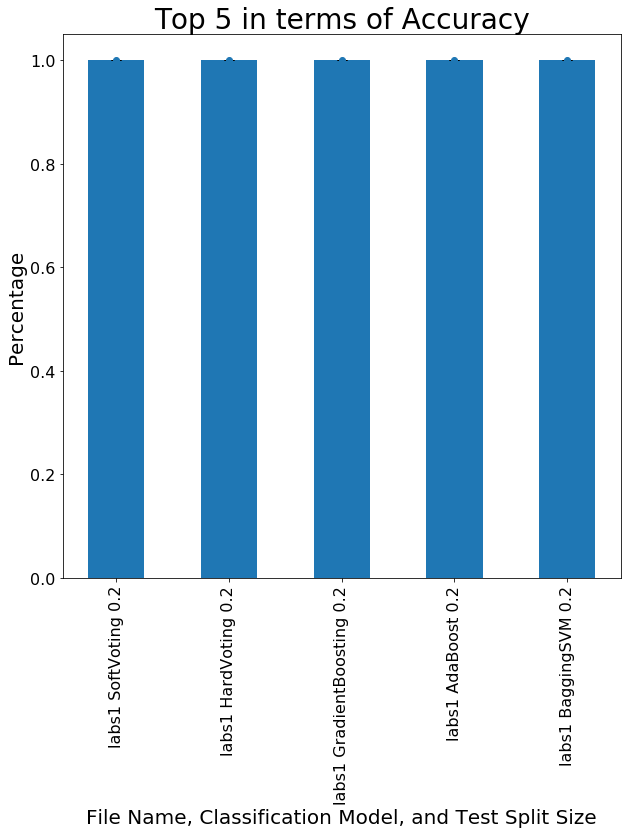

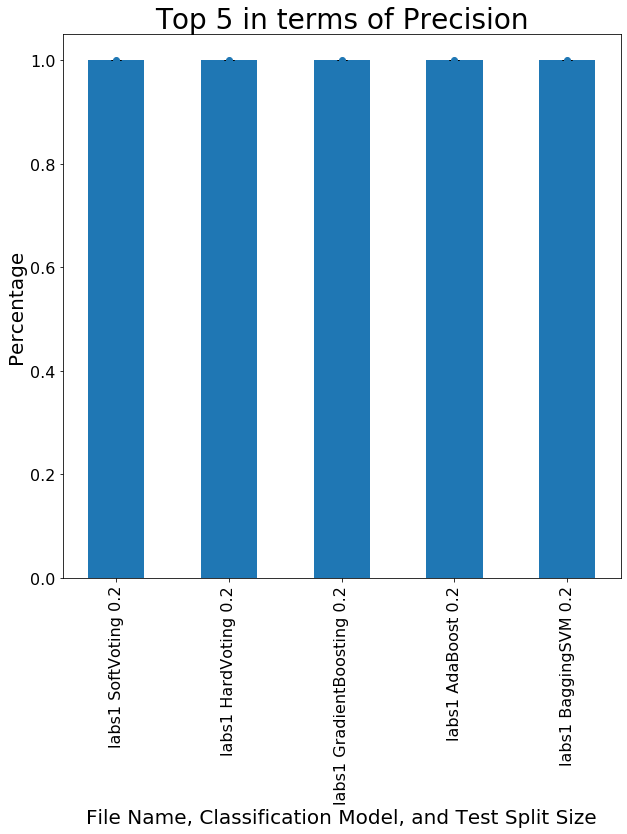

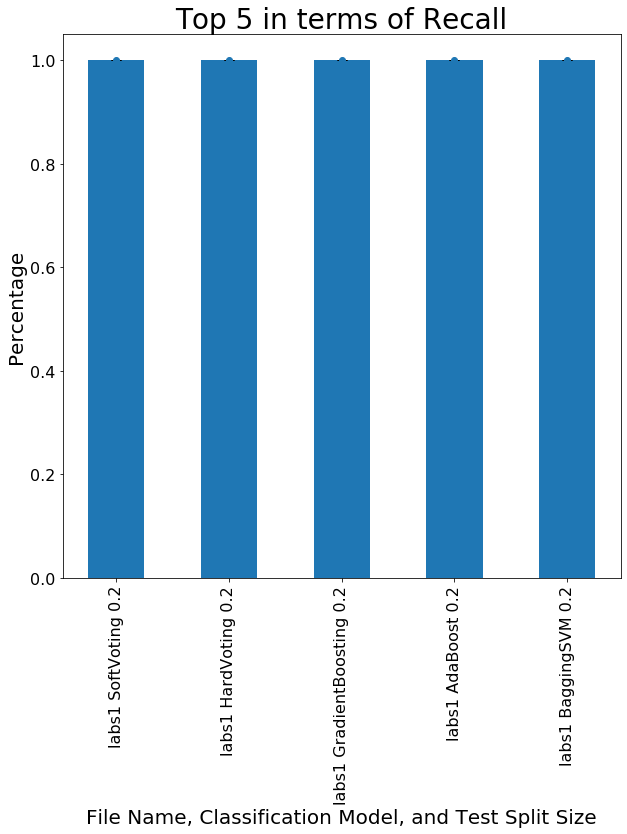

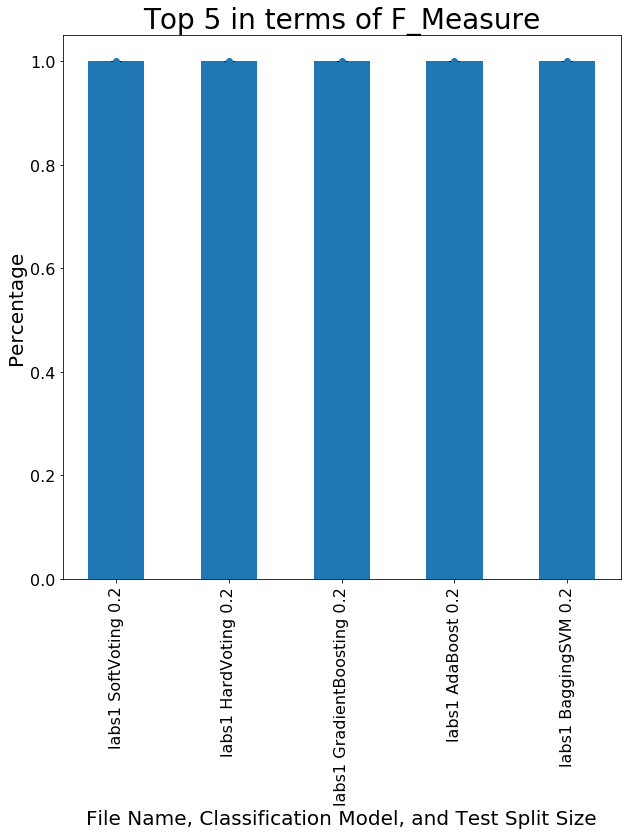

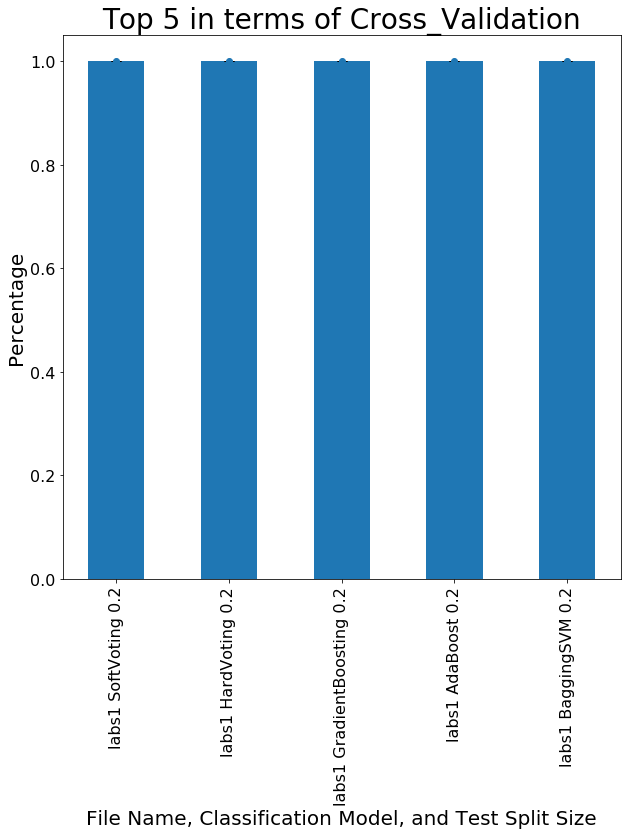

In [354]:
All = getTopXForAllDatasets(datasetClasses,5)

graphTopXStatInfo(All)


### Analysis

Due to the nature of artificially generated data, it is expected to see results of 100% Accuracy, Precision, Recall, and F-Measure across all models. Dataset2 was created in an attempt to more closely mirror real data sets. When we run the analysis on just dataset2 we can see the standard deviation in the accuracy of the ML models.


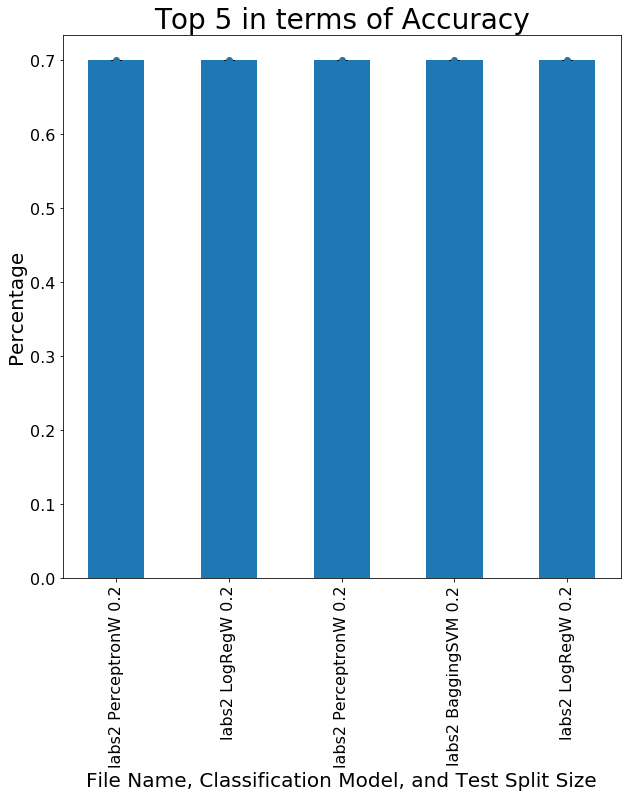

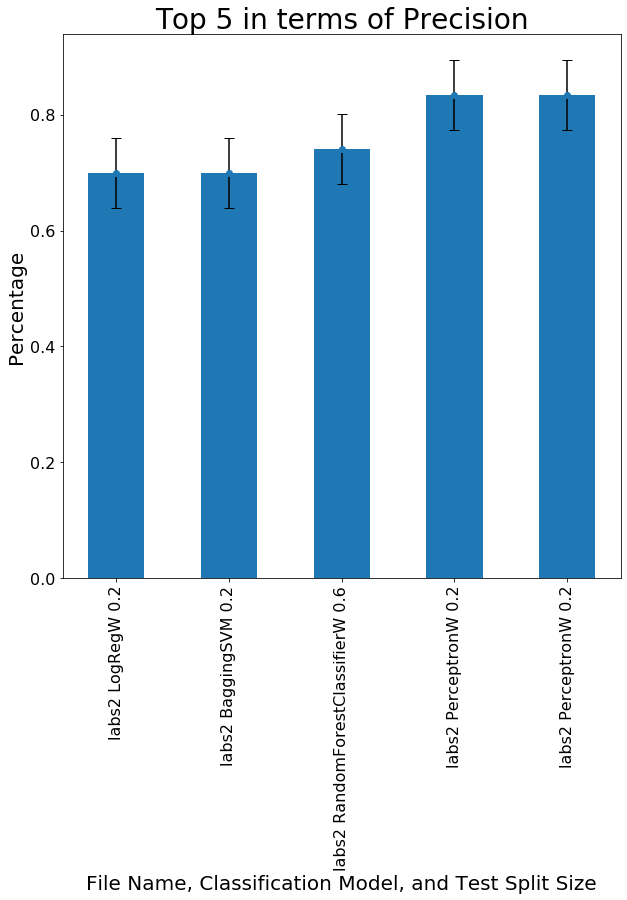

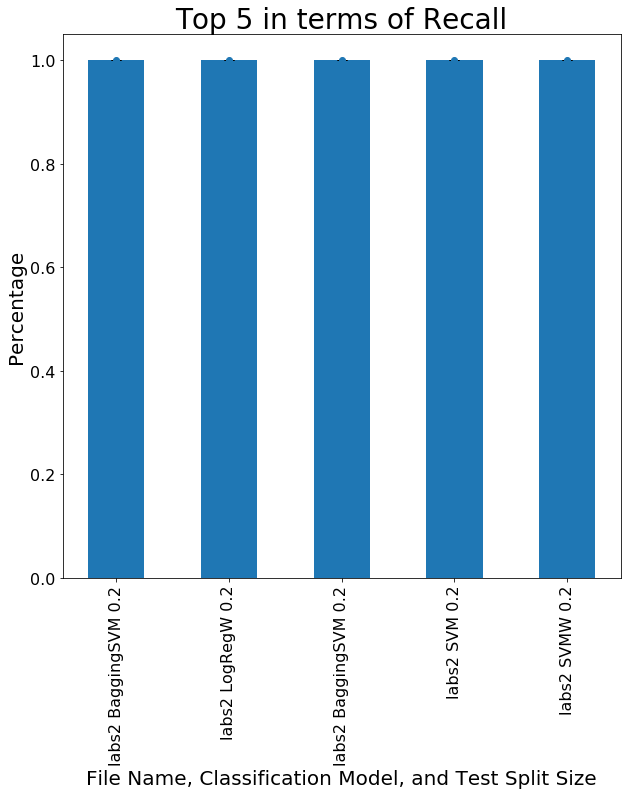

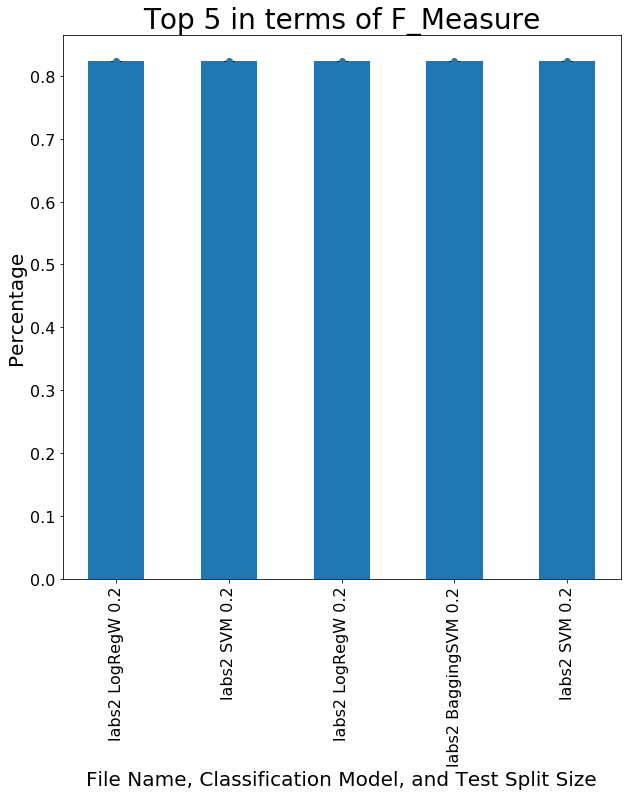

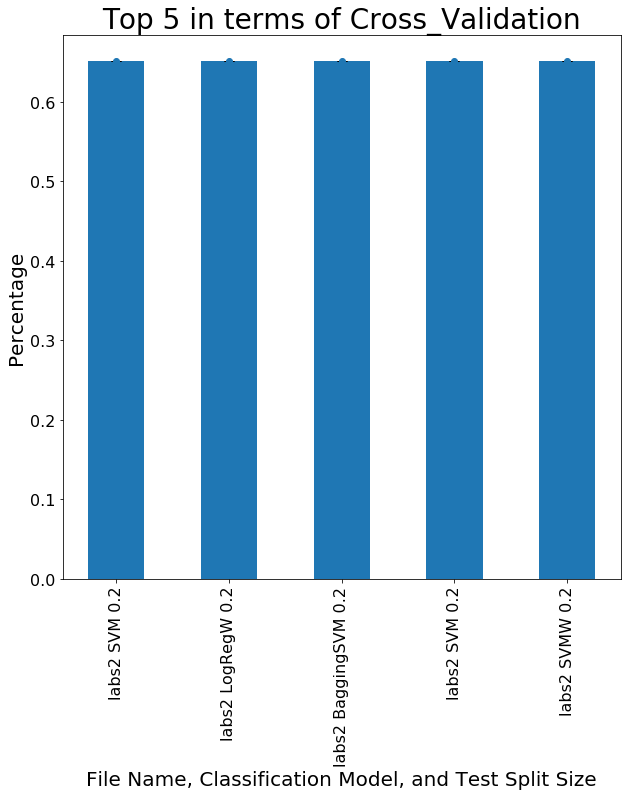

In [355]:
ds2 = getTopXForAllDatasets(datasetClassesJust2,5)

graphTopXStatInfo(ds2)

#### Additional Functionality

The mock data created had no missing data points. This was done to mirror the expected data collected, as we had decided to exclude participants who did not have complete datasets. However, if the implementation of this model ends up being done on incomplete datasets, the following ibmlearn libraries can be run to deal with undersampling and oversampling issues that may arise.

In [358]:
#underSampledModels = []
#from imblearn.under_sampling import RandomUnderSampler
#underSampledModels.append("-UnderSampledRandom",RandomUnderSampler())
#overSampledModels = []
#from imblearn.over_sampling import RandomOverSampler
#overSampledModels.append("-OverSampledRandom",RandomOverSampler())


### References

Yuan Luo, MS, Peter Szolovits, PhD, Anand S. Dighe, MD, PhD, Jason M. Baron, MD, Using Machine Learning to Predict Laboratory Test Results, American Journal of Clinical Pathology, Volume 145, Issue 6, June 2016, Pages 778–788, https://doi.org/10.1093/ajcp/aqw064

C. Werner, Z. S. Li and D. Damian, "Can a Machine Learn Through Customer Sentiment?: A Cost-Aware Approach to Predict Support Ticket Escalations," in IEEE Software, vol. 36, no. 5, pp. 38-45, Sept.-Oct. 2019.
